<a href="https://colab.research.google.com/github/sehamhemdan/Text-Classification/blob/main/deep_learning_models_for_stanford_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
tf.config.list_physical_devices('GPU') 

[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
working_dir_path ='/content/drive/MyDrive/preprocessedStanford_sentiment.csv'
df = pd.read_csv(working_dir_path)
#corpus.label = corpus.label.astype(int)
print(df.shape)


Mounted at /content/drive
(1600000, 2)


In [ ]:
# load dataset
#df=df.drop_duplicates(inplace = True)
df = df.dropna(how='any',axis=0)

In [ ]:
df['target'][df['target']==4]=1

In [ ]:
from traitlets.traitlets import default
#Separating positive and negative tweets
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]
df = pd.concat([data_pos, data_neg])

In [ ]:
# load dataset
#df=df.drop_duplicates(inplace = True)
df = df.dropna(how='any',axis=0)

In [ ]:
# convert label to a numerical variable
##df['label'] = df.airline_sentiment.map({'positive':2, 'neutral':1,'negative':0})
df.tail()

,target,new_text
799995,0,sick spend day lay bed listen
799996,0,gmail down
799997,0,rest peac farrah sad
799998,0,sound like rival flag your ad not much you can...
799999,0,ha resit exam over summer wish work harder fir...


In [ ]:
# Separating positive and negative rows
df_pos = df[df['target'] == 1]
df_neg = df[df['target'] == 0]
print(len(df_pos), len(df_neg))

797483 797847


In [ ]:
# Only retaining 1/4th of our data from each output group
# Feel free to alter the dividing factor depending on your workspace
# 1/64 is a good place to start if you're unsure about your machine's power
df_pos = df_pos.iloc[:int(len(df_pos)/4)]
df_neg = df_neg.iloc[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

199370 199461


In [ ]:
# Concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

398831

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(df['new_text'], df['target'], test_size = 0.2, stratify = df['target'])

In [ ]:
xtrain.shape

(319064,)

In [ ]:
xvalid.shape

(79767,)

In [ ]:
df['new_text'].apply(lambda x:len(str(x).split())).max()

29

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 35

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
%%time

# A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,100,input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           10065900  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,086,101
Trainable params: 10,086,101
Non-trainable params: 0
_________________________________________________________________
CPU times: user 243 ms, sys: 1.92 ms, total: 245 ms
Wall time: 201 ms


In [ ]:
#EarlyStopping and ModelCheckpoint
tf.random.set_seed(7)
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 2, patience = 2)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
%%time
history_embedding = model.fit(xtrain_pad,ytrain, epochs = 4, batch_size = 128,
                              validation_data=(xvalid_pad, yvalid),verbose = 1, callbacks= [es, mc]  )

Epoch 1/4
2493/2493 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7659
Epoch 1: val_accuracy improved from -inf to 0.78499, saving model to ./model.h5
2493/2493 [==============================] - 368s 147ms/step - loss: 0.4858 - accuracy: 0.7659 - val_loss: 0.4589 - val_accuracy: 0.7850
Epoch 2/4
2493/2493 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8176
Epoch 2: val_accuracy did not improve from 0.78499
2493/2493 [==============================] - 300s 120ms/step - loss: 0.4063 - accuracy: 0.8176 - val_loss: 0.4661 - val_accuracy: 0.7838
Epoch 3/4
2493/2493 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8548
Epoch 3: val_accuracy did not improve from 0.78499
2493/2493 [==============================] - 297s 119ms/step - loss: 0.3350 - accuracy: 0.8548 - val_loss: 0.5022 - val_accuracy: 0.7695
Epoch 3: early stopping
CPU times: user 25min 47s, sys: 37.9 s, total: 26min 25s
Wall time: 16min 4s


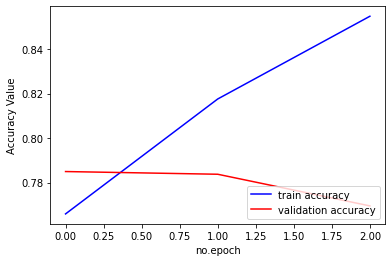

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy Value")
plt.xlabel("no.epoch")
plt.savefig("SNN_Acc_d2.png")
plt.show()

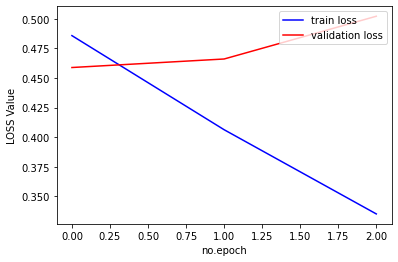

In [ ]:
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel("LOSS Value")
plt.xlabel("no.epoch")
plt.savefig("SNN_LOSS_d2.png")
plt.show()

In [ ]:
preds=model.predict(xvalid_pad)

In [ ]:
from sklearn.metrics import f1_score

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = np.argmax(preds, axis=1)

# Print f1, precision, and recall scores
print(precision_score(yvalid, y_pred , average="macro"))
print(recall_score(yvalid, y_pred , average="macro"))
print(f1_score(yvalid, y_pred , average="macro"))

0.2500595484348164
0.5
0.33338626107304026


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.85%


In [ ]:
scores_model = []

In [ ]:

scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-05 06:28:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-05 06:28:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-05 06:28:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:42, 9464.81it/s]

Found 400000 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 100658/100658 [00:00<00:00, 535758.79it/s]


In [ ]:
%%time

    
# A simple LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 300)           30197700  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 30,358,201
Trainable params: 160,501
Non-trainable params: 30,197,700
_________________________________________________________________
CPU times: user 633 ms, sys: 287 ms, total: 919 ms
Wall time: 655 ms


In [ ]:
#EarlyStopping and ModelCheckpoint
tf.random.set_seed(7)
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 2, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
%%time
history_embedding = model.fit(xtrain_pad,ytrain, epochs = 20, batch_size = 128,
                              validation_data=(xvalid_pad, yvalid),verbose = 1, callbacks= [es, mc]  )

Epoch 1/20
2493/2493 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7360
Epoch 1: val_accuracy improved from -inf to 0.76604, saving model to ./model.h5
2493/2493 [==============================] - 636s 254ms/step - loss: 0.5236 - accuracy: 0.7360 - val_loss: 0.4832 - val_accuracy: 0.7660
Epoch 2/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.7688
Epoch 2: val_accuracy improved from 0.76604 to 0.77708, saving model to ./model.h5
2493/2493 [==============================] - 632s 254ms/step - loss: 0.4779 - accuracy: 0.7688 - val_loss: 0.4642 - val_accuracy: 0.7771
Epoch 3/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.7776
Epoch 3: val_accuracy improved from 0.77708 to 0.78174, saving model to ./model.h5
2493/2493 [==============================] - 631s 253ms/step - loss: 0.4623 - accuracy: 0.7776 - val_loss: 0.4587 - val_accuracy: 0.7817
Epoch 4/20
2493/2493 [===========================

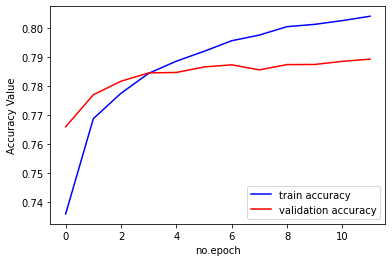

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy Value")
plt.xlabel("no.epoch")
plt.savefig("LSTM_Acc_d2.png")
plt.show()

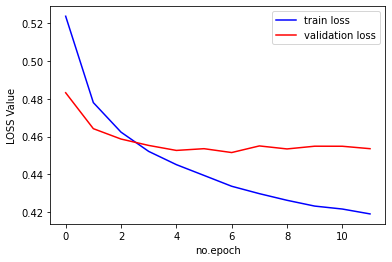

In [ ]:
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel("LOSS Value")
plt.xlabel("no.epoch")
plt.savefig("LSTM_LOSS_d2.png")
plt.show()

In [ ]:
preds=model.predict(xvalid_pad)

In [ ]:
from sklearn.metrics import f1_score

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = np.argmax(preds, axis=1)

# Print f1, precision, and recall scores
print(precision_score(yvalid, y_pred , average="macro"))
print(recall_score(yvalid, y_pred , average="macro"))
print(f1_score(yvalid, y_pred , average="macro"))

0.2500595484348164
0.5
0.33338626107304026


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.88%


In [ ]:
scores_model = []
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})

In [ ]:
#GRU
%%time

# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 300)           30197700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 35, 300)          0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               540900    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 30,738,901
Trainable params: 541,201
Non-trainable params: 30,197,700
_________________________________________________________________
CPU times: user 634 ms, sys: 231 ms, total: 864 ms
Wall time: 585 ms


In [ ]:
#EarlyStopping and ModelCheckpoint
tf.random.set_seed(7)
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 2, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
%%time
history_embedding = model.fit(xtrain_pad,ytrain, epochs = 20, batch_size = 128,
                              validation_data=(xvalid_pad, yvalid),verbose = 1, callbacks= [es, mc]  )

Epoch 1/20
2493/2493 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7394
Epoch 1: val_accuracy improved from -inf to 0.76805, saving model to ./model.h5
2493/2493 [==============================] - 1391s 557ms/step - loss: 0.5185 - accuracy: 0.7394 - val_loss: 0.4786 - val_accuracy: 0.7680
Epoch 2/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.7738
Epoch 2: val_accuracy improved from 0.76805 to 0.78080, saving model to ./model.h5
2493/2493 [==============================] - 1364s 547ms/step - loss: 0.4691 - accuracy: 0.7738 - val_loss: 0.4574 - val_accuracy: 0.7808
Epoch 3/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.7879
Epoch 3: val_accuracy improved from 0.78080 to 0.78487, saving model to ./model.h5
2493/2493 [==============================] - 1361s 546ms/step - loss: 0.4474 - accuracy: 0.7879 - val_loss: 0.4525 - val_accuracy: 0.7849
Epoch 4/20
2493/2493 [========================

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy Value")
plt.xlabel("no.epoch")
plt.savefig("GRU_Acc_d2.png")
plt.show()

In [ ]:
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel("LOSS Value")
plt.xlabel("no.epoch")
plt.savefig("GRU_LOSS_d2.png")
plt.show()

In [ ]:
#bidirectional

In [ ]:
%%time

# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           30197700  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 30,518,701
Trainable params: 321,001
Non-trainable params: 30,197,700
_________________________________________________________________
CPU times: user 1.06 s, sys: 352 ms, total: 1.41 s
Wall time: 1.28 s


In [ ]:
#EarlyStopping and ModelCheckpoint
tf.random.set_seed(7)
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 2, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
%%time
history_embedding = model.fit(xtrain_pad,ytrain, epochs = 20, batch_size = 128,
                              validation_data=(xvalid_pad, yvalid),verbose = 1, callbacks= [es, mc]  )

Epoch 1/20
2493/2493 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7378
Epoch 1: val_accuracy improved from -inf to 0.76833, saving model to ./model.h5
2493/2493 [==============================] - 1323s 527ms/step - loss: 0.5214 - accuracy: 0.7378 - val_loss: 0.4793 - val_accuracy: 0.7683
Epoch 2/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.7699
Epoch 2: val_accuracy improved from 0.76833 to 0.77808, saving model to ./model.h5
2493/2493 [==============================] - 1321s 530ms/step - loss: 0.4764 - accuracy: 0.7699 - val_loss: 0.4635 - val_accuracy: 0.7781
Epoch 3/20
2493/2493 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.7805
Epoch 3: val_accuracy improved from 0.77808 to 0.78269, saving model to ./model.h5
2493/2493 [==============================] - 1317s 528ms/step - loss: 0.4593 - accuracy: 0.7805 - val_loss: 0.4555 - val_accuracy: 0.7827
Epoch 4/20
2493/2493 [========================

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy Value")
plt.xlabel("no.epoch")
plt.savefig("bi_Acc_d2.png")
plt.show()

In [ ]:
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel("LOSS Value")
plt.xlabel("no.epoch")
plt.savefig("bi_LOSS_d2.png")
plt.show()

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})

In [ ]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')